### 데이터셋 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

train=pd.read_csv('/content/drive/MyDrive/따릉이/train.csv')
test=pd.read_csv('/content/drive/MyDrive/따릉이/test.csv')

In [3]:
all_data=pd.concat([train,test],ignore_index=True)
all_data=all_data.drop('count',axis=1)
all_data.shape

(2174, 10)

In [4]:
#결측치 대체
imputer = IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=5, sample_posterior=True)
all_data_transform=pd.DataFrame(imputer.fit_transform(all_data),columns=all_data.columns)
all_data_transform.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

In [5]:
target=train['count']
train=all_data_transform.iloc[:1459,:]
test=all_data_transform.iloc[1459:,:]

### 모델 선택

In [123]:
rf=RandomForestRegressor(n_estimators=1000,random_state=0)
xgb=XGBRegressor()
lgbm=LGBMRegressor()
ridge=Ridge(alpha=0.5)
lasso=Lasso(alpha=0.5)
dt=DecisionTreeRegressor()

model_lsit=[rf,xgb,lgbm,ridge,lasso,dt]

def get_mse_socre(model,X_train,y_train):
  scores=cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
  return scores.mean()

for model in model_lsit:
  mse=get_mse_socre(model,train,target)
  print(model.__class__.__name__+'mse:',-mse)

RandomForestRegressormse: 1539.1482866124793
[14:53:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressormse: 1679.359582643149
LGBMRegressormse: 1595.5308088291777
Ridgemse: 2809.0513626785896
Lassomse: 2829.386111262448
DecisionTreeRegressormse: 3026.567900014122


* RandomForestRegressor이 가장 성능이 좋음

##### RandomForestRegreossor의 Hyperparameter tuning
* Bayesian Optimization으로 최적화 수행


In [26]:
# bayesian optimization 패키지 설치
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=45dbf6bdd953a4fa9f212897f91ecb980a665933607ad9613aea622de096c7e2
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [53]:
bayesian_params={
    'n_estimators':(500,2000)
}

def rf_mse(n_estimators):
  params={
      'n_estimators':int(round(n_estimators)) }
  rf=RandomForestRegressor(**params)
  scores=cross_val_score(rf,train,target,scoring='neg_mean_squared_error',cv=5)

  return scores.mean()


###### BayesianOptimization 객체 생성 후 함수 반환값이 최대가 되는 입력값 search를 위한 iteration 수행

In [54]:
from bayes_opt import BayesianOptimization
rfBO=BayesianOptimization(rf_mse,bayesian_params)
rfBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | n_esti... |
-------------------------------------
|  1        | -1.53e+03 |  1.775e+0 |
|  2        | -1.536e+0 |  1.436e+0 |
|  3        | -1.536e+0 |  1.631e+0 |
|  4        | -1.53e+03 |  556.7    |
|  5        | -1.526e+0 |  1.973e+0 |
|  6        | -1.525e+0 |  1.973e+0 |
|  7        | -1.525e+0 |  1.974e+0 |
|  8        | -1.531e+0 |  1.974e+0 |
|  9        | -1.533e+0 |  1.946e+0 |
|  10       | -1.533e+0 |  1.145e+0 |
|  11       | -1.535e+0 |  1.408e+0 |
|  12       | -1.519e+0 |  607.0    |
|  13       | -1.534e+0 |  1.074e+0 |
|  14       | -1.532e+0 |  1.796e+0 |
|  15       | -1.536e+0 |  1.331e+0 |
|  16       | -1.532e+0 |  1.354e+0 |
|  17       | -1.531e+0 |  884.3    |
|  18       | -1.527e+0 |  872.7    |
|  19       | -1.531e+0 |  601.4    |
|  20       | -1.525e+0 |  1.185e+0 |
|  21       | -1.526e+0 |  840.4    |
|  22       | -1.538e+0 |  649.6    |
|  23       | -1.534e+0 |  1.541e+0 |
|  24       | -1.529e+0 |  1.847e+0 |
|  25       

##### Iteration 수행 결과 출력

In [55]:
rfBO.res

[{'params': {'n_estimators': 1774.6905909980032},
  'target': -1530.193668960903},
 {'params': {'n_estimators': 1436.095914180596},
  'target': -1535.6082677066015},
 {'params': {'n_estimators': 1631.163229258844},
  'target': -1536.0203259708846},
 {'params': {'n_estimators': 556.7363783537367},
  'target': -1530.4490122362106},
 {'params': {'n_estimators': 1973.0463264939865},
  'target': -1526.4024708559616},
 {'params': {'n_estimators': 1973.391165503006},
  'target': -1524.5670363971828},
 {'params': {'n_estimators': 1973.5564557026942},
  'target': -1525.4447475876564},
 {'params': {'n_estimators': 1973.5242188900936},
  'target': -1530.9587187235352},
 {'params': {'n_estimators': 1946.2152344832823},
  'target': -1532.9898491613799},
 {'params': {'n_estimators': 1144.5359016399889},
  'target': -1532.9597881346376},
 {'params': {'n_estimators': 1407.9013369538477},
  'target': -1534.7678763875867},
 {'params': {'n_estimators': 606.9545403272905},
  'target': -1519.3355053065484}

##### Iteration 결과에서 최적의 parameter 값 추출

In [56]:
target_list=[]

for result in rfBO.res:
  target_list.append(result['target'])
print(target_list)
print('maximum target index:',np.argmax(np.array(target_list)))

[-1530.193668960903, -1535.6082677066015, -1536.0203259708846, -1530.4490122362106, -1526.4024708559616, -1524.5670363971828, -1525.4447475876564, -1530.9587187235352, -1532.9898491613799, -1532.9597881346376, -1534.7678763875867, -1519.3355053065484, -1533.5516009772987, -1531.6113617094675, -1535.597728449721, -1532.2431073257856, -1531.001343533271, -1527.205156146392, -1531.224907155853, -1525.078501653136, -1526.192739599472, -1537.9761813444595, -1533.6880234983796, -1528.8755987303398, -1541.6000341959905, -1530.4400310411443, -1535.6706020144907, -1530.2593186910854, -1535.6479611216369, -1540.0811697251931]
maximum target index: 11


In [57]:
max_dic=rfBO.res[np.argmax(np.array(target_list))]
print(max_dic)

{'target': -1519.3355053065484, 'params': {'n_estimators': 606.9545403272905}}


#### 최적화된 hyperparameter로 재 테스트

In [58]:
rf=RandomForestRegressor(n_estimators=606,
                         max_depth=13,
                         max_leaf_nodes=57,
                         min_samples_leaf=8,
                         min_samples_split=31,random_state=0)
score=cross_val_score(rf,train,target,scoring='neg_mean_squared_error',cv=5)

KeyboardInterrupt: ignored

In [46]:
score.mean()

-1715.7001575227216

In [101]:
rf.fit(train.drop('id',axis=1),target)
pred=rf.predict(test.drop('id',axis=1))

submission=pd.read_csv("/content/drive/MyDrive/따릉이/submission.csv")
submission['count']=pred
submission.to_csv("/content/drive/MyDrive/따릉이/submission05-2.csv",index=False)
submission.head(10)

,id,count
0,0,86.473597
1,1,224.420792
2,2,75.622112
3,4,29.036304
4,5,74.453795
5,10,126.787129
6,11,190.957096
7,12,317.651815
8,15,33.402640
9,17,129.712871


In [102]:
rf=RandomForestRegressor(n_estimators=1000,random_state=0)
score=cross_val_score(rf,train.drop('id',axis=1),target,scoring='neg_mean_squared_error',cv=5)
score.mean()

-1504.913910556562

<BarContainer object of 9 artists>

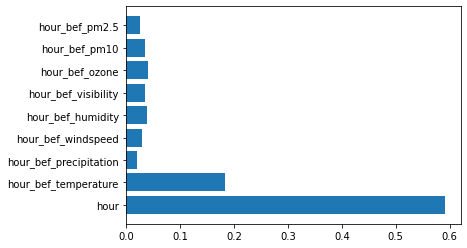

In [100]:
plt.barh(train.drop('id',axis=1).columns,rf.feature_importances_)

#### 하이퍼 파라미터를 튜닝했더니 성능이 더 저하됨..